<h1>Data Preparation</h1>

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
df = pd.read_csv(url)

# Keep only the required columns
columns = ["Make", "Model", "Year", "Engine HP", "Engine Cylinders", "Transmission Type", "Vehicle Style", "highway MPG", "city mpg", "MSRP"]
df = df[columns]

# Lowercase column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Fill missing values with 0
df = df.fillna(0)

# Make the price binary
df['above_average'] = (df['msrp'] > df['msrp'].mean()).astype(int)

# Split the data into train/validation/test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2


<h1>ROC AUC Feature Selection & Importance</h1>

In [33]:
from sklearn.metrics import roc_auc_score

numerical_vars = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

best_auc = 0
best_var = ""

for var in numerical_vars:
    auc = roc_auc_score(df_train['above_average'], df_train[var])
    if auc < 0.5:
        auc = roc_auc_score(df_train['above_average'], -df_train[var])

    if auc > best_auc:
        best_auc = auc
        best_var = var

print(f"Question 1: {best_var} has the highest AUC")


Question 1: engine_hp has the highest AUC


<h1>Model Training</hq>

In [34]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical_vars + ["above_average"]].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
y_train = df_train['above_average']

val_dict = df_val[numerical_vars + ["above_average"]].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = df_val['above_average']

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"Question 2: AUC on the validation dataset is {auc:.3f}")


Question 2: AUC on the validation dataset is 1.000


<h1>Precision & Recall</h1>

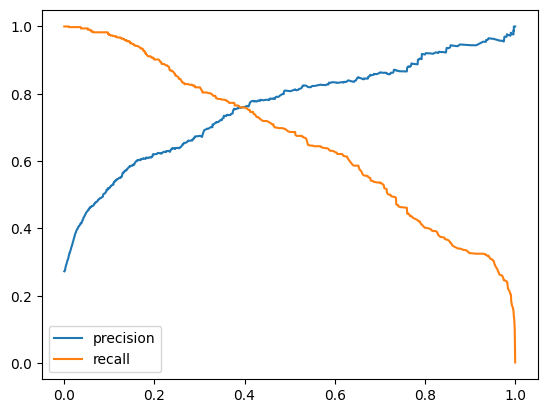

Question 3: Precision and recall curves intersect at threshold 0.40


In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

intersection_threshold = thresholds[np.argmax(precisions >= recalls)]

#Plot the precision-recall curve on all thresholds

import matplotlib.pyplot as plt

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.legend()
plt.show()

print(f"Question 3: Precision and recall curves intersect at threshold {intersection_threshold:.2f}")


<h1>F1 Score</h1>

In [36]:
from sklearn.metrics import f1_score

f1_scores = [f1_score(y_val, y_pred >= threshold) for threshold in thresholds]

max_f1_threshold = thresholds[np.argmax(f1_scores)]
print(f"Question 4: F1 is maximal at threshold {max_f1_threshold:.2f}")


Question 4: F1 is maximal at threshold 0.84


<h1>Cross Validation</h1>

In [37]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kf.split(df_full_train):
    train_data, val_data = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]

    X_train = dv.transform(train_data[numerical_vars].to_dict(orient='records'))
    y_train = train_data['above_average']

    X_val = dv.transform(val_data[numerical_vars].to_dict(orient='records'))
    y_val = val_data['above_average']

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

std_dev = np.std(scores)
print(f"Question 5: Standard deviation of scores across different folds is {std_dev:.3f}")

# Hyperparameter Tuning
C_values = [0.01, 0.1, 0.5, 10]
mean_scores = []

for C in C_values:
    scores = []
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

    for train_idx, val_idx in kf.split(df_full_train):
        train_data, val_data = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]

        X_train = dv.transform(train_data[numerical_vars].to_dict(orient='records'))
        y_train = train_data['above_average']

        X_val = dv.transform(val_data[numerical_vars].to_dict(orient='records'))
        y_val = val_data['above_average']

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_score = np.mean(scores)
    mean_scores.append(mean_score)

best_C_idx = np.argmax(mean_scores)
best_C = C_values[best_C_idx]
std_dev_best_C = np.std(scores)
print(f"Question 6: Best C is {best_C}, Mean score is {mean_scores[best_C_idx]:.3f}, Std deviation is {std_dev_best_C:.3f}")


Question 5: Standard deviation of scores across different folds is 0.003
Question 6: Best C is 10, Mean score is 0.932, Std deviation is 0.003
